In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract, round, sqrt, pow, lit

In [2]:
spark = SparkSession.builder.appName('event_data').getOrCreate()

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/21 20:26:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
events = spark.read.csv('Data/events.csv',header=True,inferSchema=True,sep=';')

In [7]:
events_shot = events.filter(events.type == 'Shot')

In [8]:
def split_location(df):
    df_l = df.withColumn("shot_location_x", regexp_extract(col("location"), r'\[(.*?),', 1).cast("float")) \
             .withColumn("shot_location_y", regexp_extract(col("location"), r', (.*?)\]', 1).cast("float")).drop('location')
    return df_l

In [9]:
def distance_to_goal(df):
    goal_x = 120
    goal_y = 40
    df = df.withColumn("distance_to_goal", round(sqrt(pow(df.shot_location_x - lit(goal_x), 2) + pow(df.shot_location_y - lit(goal_y), 2)),4))

    return df

In [10]:
events_shot = split_location(events_shot)

In [11]:
events_shot = distance_to_goal(events_shot)

In [9]:
events_shot.show()

24/12/20 16:02:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+--------------------+------------------------------+------------------+--------------------+------------+--------------+---------------+---------------+------------+---------+--------+------------------------+-------------------+------------------+------------------+--------------------+-----------------------+------------------+-------------------+--------------------+---------------+--------------------+-----+--------------------+--------+------+---------------+----------+---------------------+-------------+--------------+----------+-------------+--------------+-----------------+----------------+-----------+-----------+------------+--------------+-----------------+----------------+-----------+---------+------+--------------+--------------------+---------+--------------------+----------+---------------+------------------+--------------------+------+---------------+--------------+------------------+---------------+--------------------+--------------------+---------------+-------

In [15]:
events_frames = events_shot.select('id','shot_freeze_frame')

In [23]:
events_frames.show(1, False)

+------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
# draw an example of the shot location for the first 10 shots
import pandas as pd
events_shot_pd = events_shot.select('shot_location_x','shot_location_y','shot_outcome','shot_statsbomb_xg').limit(2000).toPandas()

In [15]:
events_shot_pd

,shot_location_x,shot_location_y,shot_outcome,shot_statsbomb_xg
0,105.599998,44.000000,Off T,0.072140
1,98.599998,25.200001,Saved,0.029771
2,105.500000,47.299999,Post,0.075898
3,113.400002,38.700001,Saved,0.156862
4,106.199997,36.799999,Blocked,0.151331
...,...,...,...,...
1995,107.699997,42.700001,Blocked,0.065751
1996,98.500000,60.599998,Saved,0.011382
1997,112.300003,34.799999,Off T,0.109719
1998,100.000000,32.000000,Off T,0.032623


In [16]:
events_shot_pd.value_counts('shot_outcome')

shot_outcome
Off T               606
Blocked             551
Saved               465
Goal                204
Wayward             122
Post                 41
Saved to Post         8
Saved Off Target      3
Name: count, dtype: int64

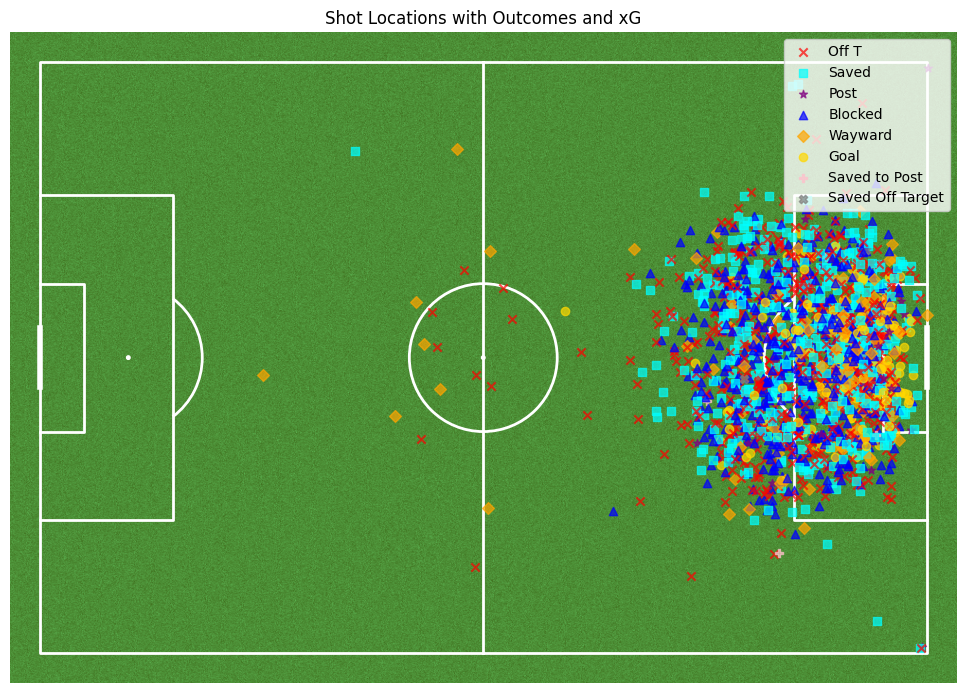

In [ ]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Initialize the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
fig, ax = pitch.draw(figsize=(10, 7))

# Define color and marker mappings for shot outcomes
outcome_styles = {
    'Goal': ('gold', 'o'),
    'Off T': ('red', 'x'),
    'Blocked': ('blue', '^'),
    'Saved': ('cyan', 's'),
    'Wayward': ('orange', 'D'),
    'Post': ('purple', '*'),
    'Saved to Post': ('pink', 'P'),
    'Saved Off Target': ('gray', 'X')
}

# Plot the shots
for i, row in events_shot_pd.iterrows():
    x, y = row['shot_location_x'], row['shot_location_y']
    xg = row['shot_statsbomb_xg']
    outcome = row['shot_outcome']
    
    # Get color and marker from the outcome
    color, marker = outcome_styles.get(outcome, ('black', 'o'))  # Default to black if unknown
    
    # Size of the marker corresponds to the xG value
    #size = xg * 500  # Scale xG for visualization
    
    ax.scatter(x, y, color=color, label=outcome, alpha=0.7, marker=marker)

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Avoid duplicate legends
ax.legend(by_label.values(), by_label.keys(), loc='upper right')

# Show the plot
plt.title('Shot Locations with Outcomes and xG')
plt.show()


In [ ]:
events.groupBy('period').count().show() # 5 is penalty shootout

In [4]:
import pp_events as pp

In [23]:
eventss = pp.preferred_foot(events)

In [6]:
eventss.show()

+---------+--------------+
|player_id|preferred_foot|
+---------+--------------+
|  30111.0|    Right Foot|
|   9923.0|    Right Foot|
|   6765.0|    Right Foot|
|  41186.0|     Left Foot|
|  12493.0|    Right Foot|
|  28368.0|    Right Foot|
|  49587.0|    Right Foot|
| 154895.0|    Right Foot|
|   6983.0|    Right Foot|
|  29531.0|    Right Foot|
|  48655.0|    Right Foot|
|  28949.0|    Right Foot|
|  24921.0|    Right Foot|
|   5206.0|    Right Foot|
|   5545.0|    Right Foot|
|   6989.0|    Right Foot|
| 290289.0|    Right Foot|
|   4440.0|    Right Foot|
|  28268.0|    Right Foot|
|   3009.0|    Right Foot|
+---------+--------------+
only showing top 20 rows



In [8]:
# join events_shot with eventss left join on player_id for both
events_shot = events_shot.join(eventss, events_shot.player_id == eventss.player_id, how='left').drop(eventss.player_id)

In [11]:
# Confirm that all the players have a preferred foot for the shots
events_shot.filter(events_shot.preferred_foot.isNull()).show()

+-----+--------------------+------------------------------+------------------+--------------------+------------+--------------+---------------+---------------+------------+---------+--------+------------------------+-------------------+------------------+------------------+--------------------+-----------------------+------------------+-------------------+--------------------+---------------+---+-----+--------------------+--------+--------+------+---------------+----------+---------------------+-------------+--------------+----------+-------------+--------------+-----------------+----------------+-----------+-----------+------------+--------------+-----------------+----------------+-----------+---------+------+------------+------+--------+----------+---------------+------------------+--------------+------+---------------+--------------+-----------------+---------------+-----------------+----------------+---------------+------------+-----------------+--------------+---------+-----------

In [12]:
events_shot.groupBy('shot_body_part').count().show()

+--------------+-----+
|shot_body_part|count|
+--------------+-----+
|    Right Foot|31623|
|     Left Foot|19880|
|          Head| 9922|
|         Other|  183|
+--------------+-----+



In [13]:
# create a column for if the shot was with the preferred foot 
events_shot = events_shot.withColumn('preferred_foot_shot', col('preferred_foot') == col('shot_body_part'))
events_shot.select('player','preferred_foot','shot_body_part','preferred_foot_shot','shot_outcome','shot_statsbomb_xg').show()

+--------------------+--------------+--------------+-------------------+------------+-----------------+
|              player|preferred_foot|shot_body_part|preferred_foot_shot|shot_outcome|shot_statsbomb_xg|
+--------------------+--------------+--------------+-------------------+------------+-----------------+
|Lionel Andrés Mes...|     Left Foot|     Left Foot|               true|     Blocked|       0.15133068|
|Davinson Sánchez ...|    Right Foot|          Head|              false|       Off T|       0.14169177|
|James David Rodrí...|     Left Foot|     Left Foot|               true|     Blocked|      0.039566465|
|Nicolás Iván Gonz...|     Left Foot|    Right Foot|              false|       Off T|       0.26291034|
|Luis Fernando Día...|    Right Foot|    Right Foot|               true|       Saved|       0.02977089|
|Jhon Adolfo Arias...|    Right Foot|          Head|              false|     Wayward|       0.02531394|
|Jhon Adolfo Arias...|    Right Foot|    Right Foot|            

In [ ]:
# function that takes a df, the boolean columns and converts them to an integer
def bool_to_int(df, bool_cols):
    for col_name in bool_cols:
        df = df.withColumn(col_name, col(col_name).cast('integer'))
    return df

In [14]:
events_shot = events_shot.withColumn('goal', col('shot_outcome') == 'Goal')

In [15]:
events_shot.select('player','preferred_foot','shot_body_part','preferred_foot_shot','goal','shot_outcome','shot_statsbomb_xg').show()

+--------------------+--------------+--------------+-------------------+-----+------------+-----------------+
|              player|preferred_foot|shot_body_part|preferred_foot_shot| goal|shot_outcome|shot_statsbomb_xg|
+--------------------+--------------+--------------+-------------------+-----+------------+-----------------+
|Lionel Andrés Mes...|     Left Foot|     Left Foot|               true|false|     Blocked|       0.15133068|
|Davinson Sánchez ...|    Right Foot|          Head|              false|false|       Off T|       0.14169177|
|James David Rodrí...|     Left Foot|     Left Foot|               true|false|     Blocked|      0.039566465|
|Nicolás Iván Gonz...|     Left Foot|    Right Foot|              false|false|       Off T|       0.26291034|
|Luis Fernando Día...|    Right Foot|    Right Foot|               true|false|       Saved|       0.02977089|
|Jhon Adolfo Arias...|    Right Foot|          Head|              false|false|     Wayward|       0.02531394|
|Jhon Adol